Autora: Júlia Pelayo Rodrigues
```
```
GitHub: @jpelax
```
```
Baseado principalmente no [PyTorch 1.2 Quickstart with Google Colab](https://medium.com/dair-ai/pytorch-1-2-quickstart-with-google-colab-6690a30c38d)

In [0]:
#importações necessárias
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms


# tamanho do pacote de dados que será carregado para a rede de uma vez
BATCH_SIZE = 5

# função que serausada para transformar os dados em tensors
transform = transforms.Compose(
    [transforms.ToTensor()])

# download do dataset de treino (e transformação em tensors)
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
# estrutura do pytorch que facilita carregar os dados para a rede neural em batches
# mais tarde usada como iterador
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

# download, transformação em tensor e criação do dataloader do dataset de teste
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)


0it [00:00, ?it/s]

9920512it [00:01, 4998396.70it/s]                             


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 122855.62it/s]           
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


1654784it [00:00, 1897905.03it/s]                            
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


8192it [00:00, 45874.09it/s]            


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


#Entendendo o dataset

In [0]:
import numpy as np 

#cria iterador do dataset de treino (com o dataloader)
train_iter = iter(trainloader)

images, labels = train_iter.next()

print(type(images)) #tipo Tensor da biblioteca torch
print(images.shape) #[tamanho_batch, 1, 28, 28] (28x28, tamanho das imagens do MNIST)

print(type(labels)) 
print(labels.shape) #[tamanho_batch] -> uma label para cada imagem


<class 'torch.Tensor'>
torch.Size([5, 1, 28, 28])
<class 'torch.Tensor'>
torch.Size([5])


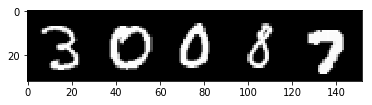

In [0]:
import matplotlib.pyplot as plt
#usando matplotlib para visualizar os dados contidos em um batch

npimgs = torchvision.utils.make_grid(images).numpy() #utilidade que transforma o tensor torch em um array numpy
plt.imshow(np.transpose(npimgs, (1, 2, 0)))


# **Construindo o modelo**
Para esse modelo serão usados 3 layers lineares, o primeiro com um input de tamanho 28*28 (784), output 500 e funçaõ de ativação ReLU, o segundo com input de tamanho 500 e saída 256, também usando ReLU, e o terceiro, o layer de output, com 10 labels de saída, usando a função de ativaçã Softmax.

In [0]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        #layer 0: 28x28 -> 500
        self.d0 = nn.Linear(784, 16)
        #layer 1: 500 -> 256
        self.d1 = nn.Linear(16, 16)
        #layer 2 (output): 256 -> 10
        self.d2 = nn.Linear(16, 10)

    def forward(self, x):
        #funçã que define como será o feedforward, não é chamada diretamente
        
        x = x.flatten(start_dim = 1) 
        
        #input passa pelo primeiro layer
        x = self.d0(x)
        x = F.relu(x)  #função de ativação

        #input passa pelo segundo layer
        x = self.d1(x)
        x = F.relu(x)
        
        #layer de output
        logits = self.d2(x)
        out = F.softmax(logits, dim=1) #usando a função de ativação softmax
        return out


In [0]:

learning_rate = 0.001
num_epochs = 5

#define se as operacoes serao executadas pela cpu ou gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

#instancia o modelo
model = Net()
model = model.to(device)

# função de erro
criterion = nn.CrossEntropyLoss()

# define o otimizador
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# computa a acuracia
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()


In [0]:
#treino
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model = model.train()
    #define que a modelo está em modo treinamento

    ## training step
    for i, (images, labels) in enumerate(trainloader):
        #manda ou para a cpu ou gpu
        images = images.to(device)
        labels = labels.to(device)

        #carrega o batch para a rede e recebe o output
        logits = model(images)
        #computa o erro
        loss = criterion(logits, labels)
        #realiza o backpropagation
        optimizer.zero_grad()
        loss.backward()

        # update dos parametros
        optimizer.step()

        # computa a loss e a acuracia
        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, BATCH_SIZE)
    
    #define que o modelo está no modo evaluation
    model.eval()
    
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss / i, train_acc/i)) 


Epoch: 0 | Loss: 1.5973 | Train Accuracy: 87.55
Epoch: 1 | Loss: 1.5365 | Train Accuracy: 92.72
Epoch: 2 | Loss: 1.5273 | Train Accuracy: 93.54
Epoch: 3 | Loss: 1.5222 | Train Accuracy: 94.00
Epoch: 4 | Loss: 1.5199 | Train Accuracy: 94.20
